__NOTE__: The 3 cells below are used to upload stuff to google colab

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip poly.zip

In [ ]:
!pip install rdkit

# Polymer Properties with CNN

In [ ]:
import sys

sys.path.append("../")

In [45]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
from torch import nn
from model.models import PolymerCNN, PolymerRNN, MLP
from model.training import train, configure
from model.data import PolymerDataset
from utils.loss import MADLoss, weightedMADLoss
from utils.vectorize import EMBED_DIM
from utils.visualize import visualize_loss

import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load in the dataset

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = PolymerDataset("../data/train.csv", device)
test_set = pd.read_csv("../data/test.csv")

### Create the model

In [ ]:
# CNN models
tg_cnn = PolymerCNN(1, (16, 32, 32, 32, 64, 128), ((4,), (2, 4, 4, 8)), 2, (1, 4), 256)
ffv_cnn = PolymerCNN(1, (32, 64, 64, 64, 128, 128), ((4, 8), (8, 16, 16, 32)), 2, (2, 4), 512)
tc_cnn = PolymerCNN(1, (16, 32, 32, 32, 64, 128), ((4,), (2, 4, 4, 8)), 2, (1, 4), 256)
density_cnn = PolymerCNN(1, (16, 32, 32, 32, 64, 128), ((4,), (2, 4, 4, 8)), 2, (1, 4), 256)
rg_cnn = PolymerCNN(1, (16, 32, 32, 32, 64, 128), ((4,), (2, 4, 4, 8)), 2, (1, 4), 256)

In [ ]:
# Configure the CNN models
tg_cnn_crit, tg_cnn_optim = configure(tg_cnn, device, MADLoss, lr=0.0001)
ffv_cnn_crit, ffv_cnn_optim = configure(ffv_cnn, device, MADLoss, lr=0.0001)
tc_cnn_crit, tc_cnn_optim = configure(tc_cnn, device, MADLoss, lr=0.0001)
density_cnn_crit, density_cnn_optim = configure(density_cnn, device, MADLoss, lr=0.0001)
rg_cnn_crit, rg_cnn_optim = configure(rg_cnn, device, MADLoss, lr=0.0001)

### Train the models

In [ ]:
from time import perf_counter

In [ ]:
cnn_models = {"tg": tg_cnn, "tc": tc_cnn, "ffv": ffv_cnn, "density": density_cnn, "rg": rg_cnn}
cnn_optimizers = {"tg":tg_cnn_optim, "tc": tc_cnn_optim, "ffv": ffv_cnn_optim, "density": density_cnn_optim, "rg": rg_cnn_optim}
cnn_criterions = {"tg": tg_cnn_crit, "tc": tc_cnn_crit, "ffv": ffv_cnn_crit, "density": density_cnn_crit, "rg": rg_cnn_crit}

In [ ]:
# Train the models
start = perf_counter()
cnn_train_history, cnn_test_history = train(cnn_models, cnn_optimizers, cnn_criterions, data, True, False, 100, 64)
end = perf_counter()
f'{end-start:.2f}s'

### Evaluate models

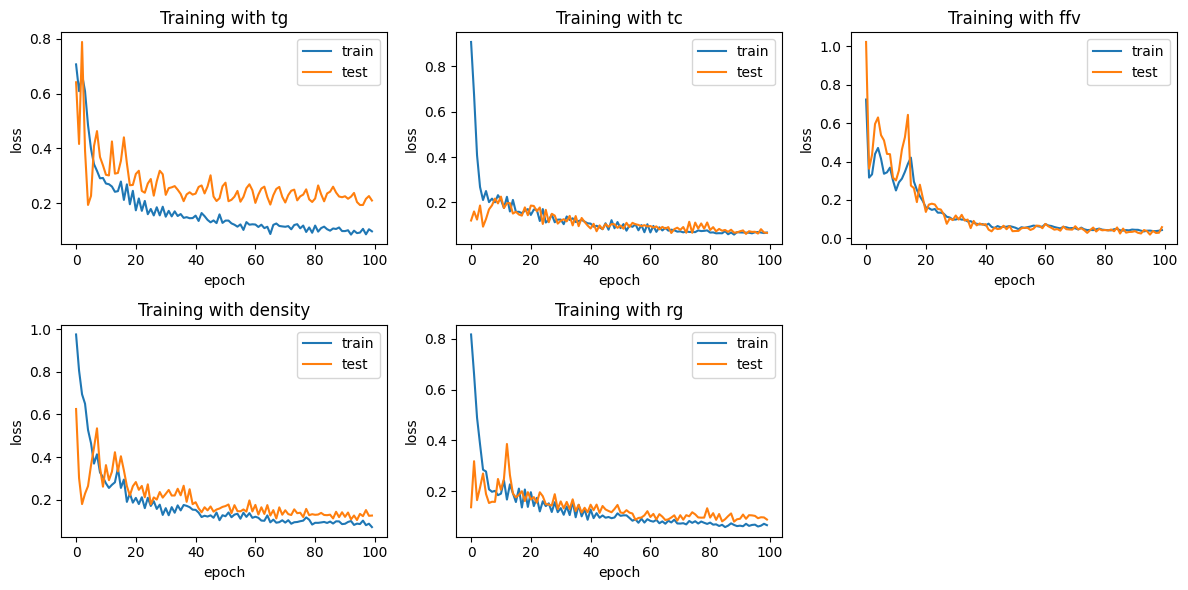

In [47]:
visualize_loss(cnn_train_history, cnn_test_history, name="CNN")

### Repeat the process for RNN

In [ ]:
# RNN models
tg_rnn = PolymerRNN(1, 1, 3, 16, (128, 64), device)
ffv_rnn = PolymerRNN(1, 1, 3, 20, (256, 512), device)
tc_rnn = PolymerRNN(1, 1, 3, 16, (128, 64), device)
density_rnn = PolymerRNN(1, 1, 3, 16, (128, 64), device)
rg_rnn = PolymerRNN(1, 1, 3, 16, (128, 64), device)

In [ ]:
# Configure the RNN models
tg_rnn_crit, tg_rnn_optim = configure(tg_rnn, device, MADLoss, lr=0.0001)
ffv_rnn_crit, ffv_rnn_optim = configure(ffv_rnn, device, MADLoss, lr=0.0001)
tc_rnn_crit, tc_rnn_optim = configure(tc_rnn, device, MADLoss, lr=0.0001)
density_rnn_crit, density_rnn_optim = configure(density_rnn, device, MADLoss, lr=0.0001)
rg_rnn_crit, rg_rnn_optim = configure(rg_rnn, device, MADLoss, lr=0.0001)

In [ ]:
rnn_models = {"tg": tg_rnn, "tc": tc_rnn, "ffv": ffv_rnn, "density": density_rnn, "rg": rg_rnn}
rnn_optimizers = {"tg":tg_rnn_optim, "tc": tc_rnn_optim, "ffv": ffv_rnn_optim, "density": density_rnn_optim, "rg": rg_rnn_optim}
rnn_criterions = {"tg": tg_rnn_crit, "tc": tc_rnn_crit, "ffv": ffv_rnn_crit, "density": density_rnn_crit, "rg": rg_rnn_crit}

In [ ]:
# Train the models
start = perf_counter()
rnn_train_history, rnn_test_history = train(rnn_models, rnn_optimizers, rnn_criterions, data, False, True, 50, 32)
end = perf_counter()
f'{end-start:.2f}s'

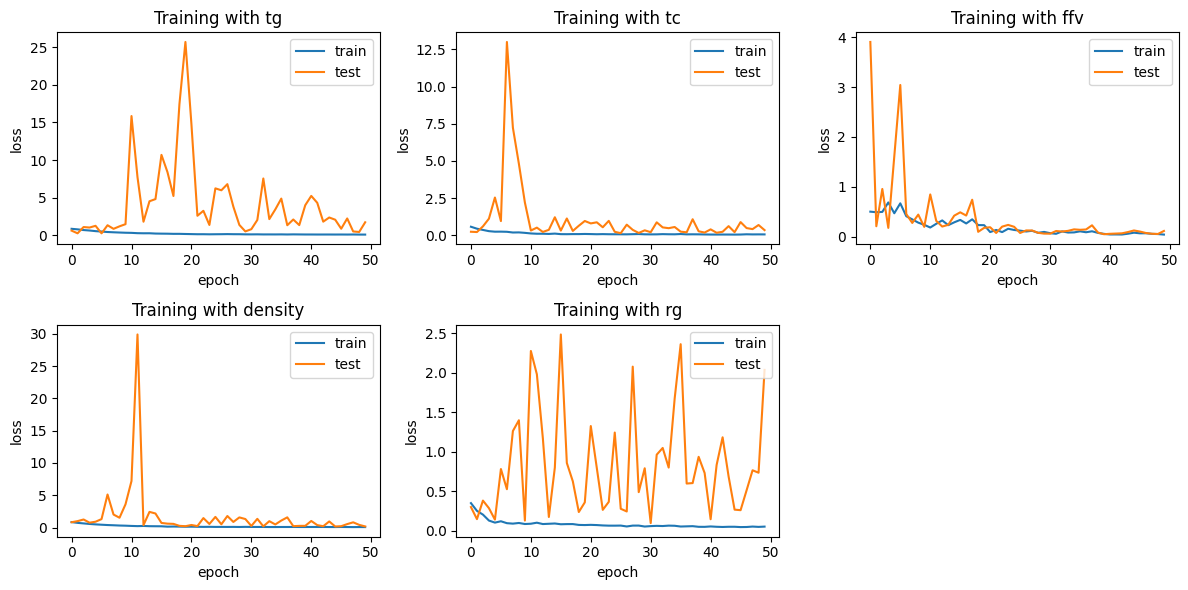

In [48]:
visualize_loss(rnn_train_history, rnn_test_history, "RNN")

### Repeat for MLP

In [ ]:
# Simple MLP
tg_mlp = MLP(1, (256, 128))
ffv_mlp = MLP(1, (1024, 512, 256))
tc_mlp = MLP(1, (256, 128))
density_mlp = MLP(1, (256, 128))
rg_mlp = MLP(1, (256, 128))

In [ ]:
# Configure the RNN models
tg_mlp_crit, tg_mlp_optim = configure(tg_mlp, device, MADLoss, lr=0.0001)
ffv_mlp_crit, ffv_mlp_optim = configure(ffv_mlp, device, MADLoss, lr=0.0001)
tc_mlp_crit, tc_mlp_optim = configure(tc_mlp, device, MADLoss, lr=0.0001)
density_mlp_crit, density_mlp_optim = configure(density_mlp, device, MADLoss, lr=0.0001)
rg_mlp_crit, rg_mlp_optim = configure(rg_mlp, device, MADLoss, lr=0.0001)

In [ ]:
mlp_models = {"tg": tg_mlp, "tc": tc_mlp, "ffv": ffv_mlp, "density": density_mlp, "rg": rg_mlp}
mlp_optimizers = {"tg":tg_mlp_optim, "tc": tc_mlp_optim, "ffv": ffv_mlp_optim, "density": density_mlp_optim, "rg": rg_mlp_optim}
mlp_criterions = {"tg": tg_mlp_crit, "tc": tc_mlp_crit, "ffv": ffv_mlp_crit, "density": density_mlp_crit, "rg": rg_mlp_crit}

In [ ]:
# Train the models
start = perf_counter()
mlp_train_history, mlp_test_history = train(mlp_models, mlp_optimizers, mlp_criterions, data, False, False, 100, 32)
end = perf_counter()
f'{end-start:.2f}s'

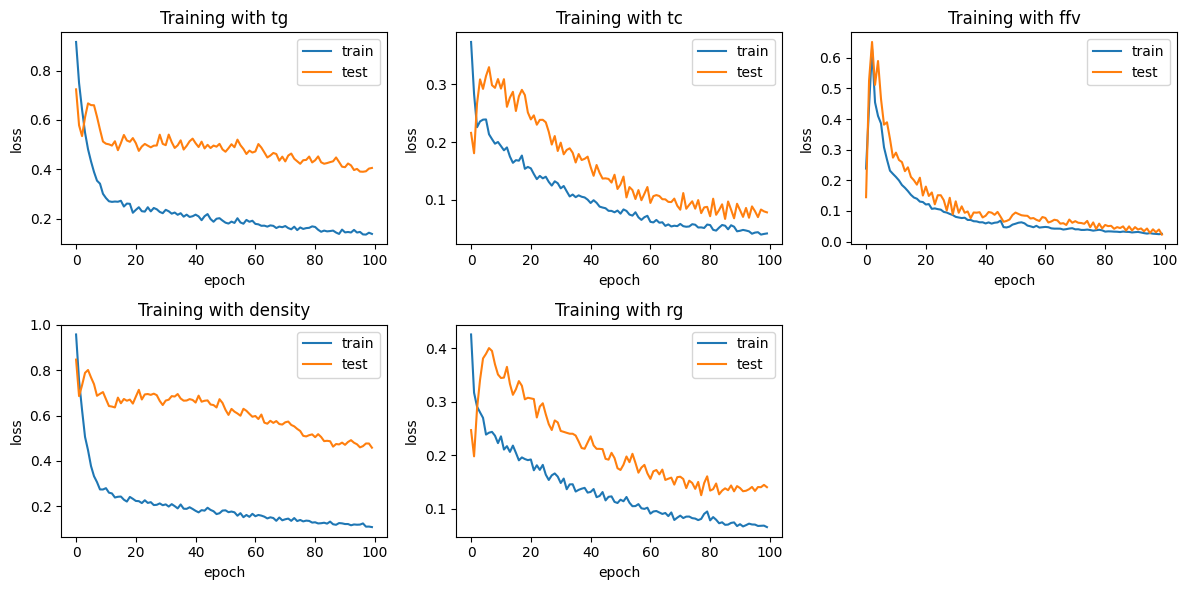

In [49]:
visualize_loss(mlp_train_history, mlp_test_history, "MLP")

### Predictions for the test set

In [ ]:
# Vectorize the text
from utils.vectorize import mol_vectorize, EMBED_DIM
import numpy as np
# Choose the model
tg_model = tg_cnn
ffv_model = ffv_mlp
tc_model = tc_cnn
density_model = density_cnn
rg_model = rg_cnn

In [ ]:
X_test = torch.from_numpy(mol_vectorize(test_set["SMILES"], embed_dim=EMBED_DIM).astype(np.float32))
X_test_cnn = X_test.view(X_test.size(0), 1, -1).to(device)
X_test_rnn = X_test.view(X_test.size(0), EMBED_DIM, 1).to(device)
X_test_mlp = X_test.to(device)

In [ ]:
# Predict
tg_outs = data.convert_tg(tg_model(X_test_cnn))
ffv_outs = ffv_model(X_test_mlp).cpu()
tc_outs = tc_model(X_test_cnn).cpu()
density_outs = density_model(X_test_cnn).cpu()
rg_outs = data.convert_rg(rg_model(X_test_cnn))

In [ ]:
# Write the result to the csv file
preds_file = "../data/submission.csv"
test_set["Tg"] = pd.Series(tg_outs.detach().view(-1))
test_set["Tc"] = pd.Series(tc_outs.detach().view(-1))
test_set["Rg"] = pd.Series(rg_outs.detach().view(-1))
test_set["Density"] = pd.Series(density_outs.detach().view(-1))
test_set["FFV"] = pd.Series(ffv_outs.detach().view(-1))

test_set.to_csv(preds_file)

In [ ]:
# Save all the model for further tuning if needed
# torch.save(tg_cnn.state_dict(), "../pretrained/tg_cnn.pth")
# torch.save(ffv_cnn.state_dict(), "../pretrained/ffv_cnn.pth")
# torch.save(tc_cnn.state_dict(), "../pretrained/tc_cnn.pth")
# torch.save(density_cnn.state_dict(), "../pretrained/density_cnn.pth")
# torch.save(rg_cnn.state_dict(), "../pretrained/rg_cnn.pth")

# torch.save(tg_rnn.state_dict(), "../pretrained/tg_rnn.pth")
# torch.save(ffv_rnn.state_dict(), "../pretrained/ffv_rnn.pth")
# torch.save(tc_rnn.state_dict(), "../pretrained/tc_rnn.pth")
# torch.save(density_rnn.state_dict(), "../pretrained/density_rnn.pth")
# torch.save(rg_rnn.state_dict(), "../pretrained/rg_rnn.pth")

# torch.save(tg_mlp.state_dict(), "../pretrained/tg_mlp.pth")
# torch.save(ffv_mlp.state_dict(), "../pretrained/ffv_mlp.pth")
# torch.save(tc_mlp.state_dict(), "../pretrained/tc_mlp.pth")
# torch.save(density_mlp.state_dict(), "../pretrained/density_mlp.pth")
# torch.save(rg_mlp.state_dict(), "../pretrained/rg_mlp.pth")